# NAM_ridge_possition.ipynb

#!/usr/bin/env python

    File name: NAM_ridge_possition.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 26.01.2021
    Date last modified: 26.01.2021

    ############################################################## 
    Purpos:
    Plots the climatological possition of the NAM ridge
    
    This requires to first run:
    ~/projects/Arizona_WTing/programs/WTing/Centroids-and-Scatterplot.py

    1) read in ERA-Interim and Modeled monthly mean ZG500 files for a common period

    2) plot the possition of the 5700 m contour line in ERA and for the April and June forecast


In [89]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from scipy import signal
from numpy.linalg import lstsq
import random

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np
import h5py
import xarray as xr

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

### Setup

In [115]:
########################################
#                            USER INPUT SECTION

NMME_dir = '/glade/collections/cdg/data/nmme/output1/'
IFS_dir = '/glade/campaign/mmm/c3we/ECMWF/'
# center/model name, ensemble members, file convention
NMME_models = [['NCAR/CESM1',10,'day_CESM1'], #['CCCMA','NASA-GMAO','NCAR/CESM1', 'NCEP','NOAA-GFDL','UM-RSMAS']
               ['NASA-GMAO/GEOS-5',10,'day_GEOS-5'], # maskes out below surface areas --> use 650 hPa level
               ['UM-RSMAS/CCSM4', 10, 'day_CCSM4'],
               ['CCCMA/CanCM4', 10, 'day_CanCM4'],  # only has 675 hPa data
               ['IFS', 25, 'day_CanCM4']] # only 7 month forecast but 25 members
ConstantFile = [NMME_dir+'NCAR/CESM1/19820101/day/atmos/hus/hus_day_CESM1_19820101_r4i1p1_19820100-19821231.nc4',
               NMME_dir+'NASA-GMAO/GEOS-5/19820101/day/atmos/hus/hus_day_GEOS-5_19820101_r1i1p1.nc',
               NMME_dir+'UM-RSMAS/CCSM4/20050801/day/atmos/hus/hus_day_CCSM4_20050801_r10i1p1_20050801-20060731.nc',
               NMME_dir+'CCCMA/CanCM4/19840101/day/atmos/v20181101/hus/hus_day_CanCM4_198401_r10i1p1_19840101-19841231.nc4',
               IFS_dir+'20050601/Q_GDS0_ISBL/Q_GDS0_ISBL_day_ECMWF_mem01_20050601.nc']
DataDir = [NMME_dir,
          NMME_dir,
          NMME_dir,
          NMME_dir,
          IFS_dir]

# for each variable we have the general varname, the netCDF var name, and the pressure level (-1 means 2D field), netCDF varname
ImputVars=[[['Z500','g',1,'G']],
            [['Z500','g',16,'g']], # level 13 is 650hPa; 850 hPa is level 6
            [['Z500','g',1,'G']],
            [['Z500','g',1,'g']],
            [['Z500','Q_GDS0_ISBL',-1,'Q_GDS0_ISBL_daily']]]

SaveDir='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/'

MONTHS=[6,7,8,9,10] # [1,2,3,4,5,6,7,8,9,10,11,12]
StartMonths=[4,6] #[2,3,4,5,6,7,8]

dStartDay=datetime.datetime(int(1993), 1, 1,12)
dStopDay=datetime.datetime(int(2010), 12, 31,12)


rgdTimeDD = pd.date_range(dStartDay, end=dStopDay, freq='d')
rgdTimeMM = pd.date_range(dStartDay, end=dStopDay, freq='m')
rgiYY=np.unique(rgdTimeDD.year)
rgdTimeDD = rgdTimeDD[np.isin(rgdTimeDD.month, MONTHS)]
rgdTimeMM = rgdTimeMM[np.isin(rgdTimeMM.month, MONTHS)]



### Load the Eucledian Distances and the Daily Precipitation for each Region

In [3]:
for re in range(len(HUC2)):
    sRegion=HUC2[re]
    ss='-'
    VarsJoint=ss.join(VarComp[re])
    sClusterSave='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Clusters'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+VarsJoint+'_'+Season
    with open(sClusterSave, 'rb') as handle:
        DATA = pickle.load(handle)
    grEucledianDist = DATA['grEucledianDist']['Full']
    rgdTime = DATA['rgdTime']
    Peval = DATA['Peval']
    ClusterArray = DATA['grClustersFin']['Full'][1]
    LonWT = DATA['LonWT']
    LatWT = DATA['LatWT']
    if re == 0:
        PR_All = np.zeros((len(rgdTime),len(HUC2))); PR_All[:]=np.nan
        PR_All_GC = np.zeros((len(rgdTime), 10000, len(HUC2))); PR_All[:]=np.nan
        Cluster_All = np.copy(PR_All)
    
    sPRsave='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Precipitation-Records_'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+sMonths+'.npz'
    npzfile = np.load(sPRsave)
    rgrPRrecords=npzfile['rgrPRrecords']
    
    PR_All[:,re] = rgrPRrecords
    PR_All_GC[:,:Peval.shape[1],re]=Peval
    
    # sort WTs from dry to wet
    TEST = np.nanmean(DATA['Peval'], axis=1)
    WT_PR = [np.nanmean(TEST[DATA['grClustersFin']['Full'][1] == wt]) for wt in range(np.max(DATA['grClustersFin']['Full'][1])+1)]
    iWT_sort = np.argsort(WT_PR)
    ClusterTMP = np.copy(ClusterArray); ClusterTMP[:] = np.nan
    for wt in range(len(iWT_sort)):
        ClusterTMP[ClusterArray == wt] = np.where(iWT_sort == wt)[0][0]
    Cluster_All[:,re] = ClusterTMP


### Calculate ERA-Interim ZG500 climatologies

In [152]:
from datetime import datetime
rgiYears=np.unique(rgdTimeDD.year)

rgsWTvars=['ZG500']
ERA_Var = ['z']
rgsWTfolders = ['/glade/campaign/mmm/c3we/prein/ERA-Interim/Z500/Z500_daymean_']

ncid=Dataset('/glade/scratch/prein/ERA-Interim/PSL/fin_PSL-sfc_ERA-Interim_12-0_2014.nc', mode='r') # open the netcdf file
rgrLatWT1D=np.squeeze(ncid.variables['lat'][:])
rgrLonWT1D=np.squeeze(ncid.variables['lon'][:])
ncid.close()
rgrLonWT=np.asarray(([rgrLonWT1D,]*rgrLatWT1D.shape[0]))
# rgrLonWT[rgrLonWT > 180]=rgrLonWT[rgrLonWT > 180]-360
rgrLatWT=np.asarray(([rgrLatWT1D,]*rgrLonWT1D.shape[0])).transpose()

DailyVars=np.zeros((len(rgdTimeDD),rgrLonWT.shape[0],rgrLonWT.shape[1])); DailyVars[:]=np.nan
for yy in range(len(rgiYears)):
    print('        Read ERA-I year: '+str(rgiYears[yy]))
    DaysYY = pd.date_range(datetime(rgiYears[yy], 1, 1,0), end=datetime(rgiYears[yy], 12, 31,23), freq='d')
    DD=((rgdTimeDD.year == rgiYears[yy]) & np.isin(rgdTimeDD.month, MONTHS))
    DDactYYYY=np.isin(DaysYY.month, MONTHS)
    # DDactYYYY=((DaysYY.month >= iStartMon) & (DaysYY.month <= iStopMon))
    for va in range(len(rgsWTvars)):
        ncid=Dataset(rgsWTfolders[va]+str(rgiYears[yy])+'.nc', mode='r')
        try:
            DailyVars[DD,:,:]=np.squeeze(np.squeeze(ncid.variables[ERA_Var[va]])[:,:,:])[DDactYYYY,:]
        except:
            stop()
        ncid.close()
        
# ERA-Interim climatological monthly means
ERAI_monclim = np.array([np.mean(DailyVars[rgdTimeDD.month == mm,:,:], axis=0) for mm in MONTHS])

### Loead the NMME ZG data

In [141]:
WTlon = np.copy(rgrLonWT[50:100,300:390])
WTlon[WTlon> 180] = WTlon[WTlon> 180]-360
WTlat = rgrLatWT[50:100,300:390]

In [232]:
from dateutil.relativedelta import relativedelta
from datetime import timedelta
from calendar import monthrange

# NMMEdata = np.zeros((sum(rgdTimeDD.year == rgiYY[0]), len(rgiYY), len(StartMonths),rgrLonT.shape[0],rgrLonT.shape[1],len(ImputVars[mo]), NMME_models[mo][1])); NMMEdata[:] = np.nan

iModels = range(4)
NMMEdata = np.zeros((sum(rgdTimeDD.year == rgiYY[0]), len(rgiYY), len(StartMonths),WTlon.shape[0],WTlat.shape[1],len(ImputVars[mo]), NMME_models[mo][1], len(iModels))); NMMEdata[:] = np.nan

for mo in range(len(iModels)):
    
    
    # ________________________________________________________________________
    # read ERA-Interim & NMME Grid
    sERAconstantFields='/glade/work/prein/reanalyses/ERA-Interim/ERA_Inerim_stationary-files_75x75.nc'
    # read the ERA-Interim elevation
    ncid=Dataset(sERAconstantFields, mode='r')
    rgrLat75=np.squeeze(ncid.variables['latitude'][:])
    rgrLon75=np.squeeze(ncid.variables['longitude'][:])
    rgrHeight=(np.squeeze(ncid.variables['z'][:]))/9.81
    rgrLSM=(np.squeeze(ncid.variables['lsm'][:]))
    ncid.close()
    rgdTimeDD_Full = pd.date_range(datetime.datetime(int(1979), 1, 1,12), end=datetime.datetime(int(2017), 12, 31,12), freq='d')

    # read NMME coordinates
    ncid=Dataset(ConstantFile[mo], mode='r')
    if 'lon' in list(ncid.variables.keys()):
        rgrLonS=np.squeeze(ncid.variables['lon'][:])
        rgrLatS=np.squeeze(ncid.variables['lat'][:])
    elif 'LON' in list(ncid.variables.keys()):
        rgrLonS=np.squeeze(ncid.variables['LON'][:])
        rgrLatS=np.squeeze(ncid.variables['LAT'][:])
    elif 'g0_lon_4' in list(ncid.variables.keys()):
        rgrLonS=np.squeeze(ncid.variables['g0_lon_4'][:])
        rgrLatS=np.squeeze(ncid.variables['g0_lat_3'][:])

    ncid.close()
    rgrLonSF, rgrLatSF = np.meshgrid(rgrLonS, rgrLatS)
    rgrLonSF[rgrLonSF>180] = rgrLonSF[rgrLonSF>180]-360

    if NMME_models[mo][0] == 'IFS':
        rgrLatSF = rgrLatSF[::-1] # IFS lat runs from N to S

    # get the region of interest
    iAddCells= 4 # grid cells added to subregion
    # iWest=np.argmin(np.abs(rgrLonT.min() - rgrLonSF[0,:]))-iAddCells
    # iEast=np.argmin(np.abs(rgrLonT.max() - rgrLonSF[0,:]))+iAddCells
    # iNort=np.argmin(np.abs(rgrLatT.max() - rgrLatSF[:,0]))+iAddCells
    # iSouth=np.argmin(np.abs(rgrLatT.min() - rgrLatSF[:,0]))-iAddCells

    iWest=np.argmin(np.abs(WTlon.min() - rgrLonSF[0,:]))-iAddCells
    iEast=np.argmin(np.abs(WTlon.max() - rgrLonSF[0,:]))+iAddCells
    iNort=np.argmin(np.abs(WTlat.max() - rgrLatSF[:,0]))+iAddCells
    iSouth=np.argmin(np.abs(WTlat.min() - rgrLatSF[:,0]))-iAddCells

    rgrLonS=rgrLonSF[iSouth:iNort,iWest:iEast]
    rgrLatS=rgrLatSF[iSouth:iNort,iWest:iEast]

    # create gregridding weights
    # Remap Gridsat to ERA5
    points=np.array([rgrLonS.flatten(), rgrLatS.flatten()]).transpose()
    # vtx, wts = interp_weights(points, np.append(rgrLonT.flatten()[:,None], rgrLatT.flatten()[:,None], axis=1))
    vtx, wts = interp_weights(points, np.append(WTlon.flatten()[:,None], WTlat.flatten()[:,None], axis=1))
    


    for yy in range(len(rgiYY)):
        print('    process '+str(rgiYY[yy]))
        DD_monsoonseason = pd.date_range(datetime.datetime(rgiYY[yy], MONTHS[0], 1,0), end=datetime.datetime(rgiYY[yy], MONTHS[-1], monthrange(rgiYY[yy], MONTHS[-1])[1],0), freq='d')
        for mm in range(len(StartMonths)):
            print('        month '+str(StartMonths[mm]))
            TIMEstamp = str(rgiYY[yy])+str(StartMonths[mm]).zfill(2)+'01'
            dStartACT=datetime.datetime(rgiYY[yy], StartMonths[mm], 1,0)
            if NMME_models[mo][0] in ['NCAR/CESM1','UM-RSMAS/CCSM4','CCCMA/CanCM4']:
                dStopACT = dStartACT + relativedelta(months=+12) - timedelta(days=1)
                rgdTimeACT = pd.date_range(dStartACT, end=dStopACT, freq='d')
            elif NMME_models[mo][0] == 'IFS':
                dStopACT = dStartACT + relativedelta(days=+214)
                rgdTimeACT = pd.date_range(dStartACT, end=dStopACT, freq='d')
            else:
                dStopACT = dStartACT + relativedelta(months=+9) - timedelta(days=1)
                rgdTimeACT = pd.date_range(dStartACT, end=dStopACT, freq='d')
            for va in range(len(ImputVars[mo])):
                if NMME_models[mo][0] == 'CCCMA/CanCM4':
                    DirNameAct = DataDir[mo]+NMME_models[mo][0]+'/'+TIMEstamp+'/day/atmos/v20181101/'+ImputVars[mo][va][1]+'/'
                elif NMME_models[mo][0] == 'IFS':
                    if (rgiYY[yy] >= 1993) & (StartMonths[mm] >= 4):
                        DirNameAct = DataDir[mo]+'/'+TIMEstamp+'/'+ImputVars[mo][va][1]+'/'
                    else:
                        continue
                else:
                    DirNameAct = DataDir[mo]+NMME_models[mo][0]+'/'+TIMEstamp+'/day/atmos/'+ImputVars[mo][va][1]+'/'

                for en in range(NMME_models[mo][1]):
                    YYYYMMDD_start = str(rgdTimeACT[0].year)+str(rgdTimeACT[0].month).zfill(2)+'00' #str(rgdTimeACT[0].day).zfill(2)
                    YYYYMMDD_stop = str(rgdTimeACT[-1].year)+str(rgdTimeACT[-1].month).zfill(2)+'*' #str(rgdTimeACT[-1].day).zfill(2)
                    if NMME_models[mo][0] == 'CCCMA/CanCM4':
                        TIMEstamp = str(rgiYY[yy])+str(StartMonths[mm]).zfill(2)
                    if NMME_models[mo][0] != 'IFS':
                        try:
                            FileName = glob.glob(DirNameAct+ImputVars[mo][va][1]+'_'+NMME_models[mo][2]+'_'+TIMEstamp+'_r'+str(en+1)+'i1p1*'+'.nc*')[0]
                        except:
                            print('            Data missing: '+DirNameAct+ImputVars[mo][va][1]+'_'+NMME_models[mo][2]+'_'+TIMEstamp+'_r'+str(en+1)+'i1p1*'+'.nc*')
                            continue
                    else:
                        try:
                            FileName = glob.glob(DirNameAct+ImputVars[mo][va][1]+'_day_ECMWF_mem'+str(en+1).zfill(2)+'*.nc')[0]
                        except:
                            continue
    #                 FileName = glob.glob(DirNameAct+ImputVars[mo][va][1]+'_'+NMME_models[mo][2]+'_'+TIMEstamp+'_r'+str(en+1)+'i1p1_'+YYYYMMDD_start+'-'+YYYYMMDD_stop+'.nc*')[0]
                    iTime = np.isin(rgdTimeACT.month, MONTHS) & np.isin(rgdTimeACT.year, rgiYY[yy])
                    # read the data
                    ncid=Dataset(FileName, mode='r')
                    if ImputVars[mo][va][2] == -1:
                        # data has no level dimension (is 3D)
                        DATAact=np.squeeze(ncid.variables[ImputVars[mo][va][3]][iTime,:,:])[:,::-1,:][:,iSouth:iNort,iWest:iEast]
                    else:
                        try:
                            DATAact=np.squeeze(ncid.variables[ImputVars[mo][va][3]][iTime,ImputVars[mo][va][2],iSouth:iNort,iWest:iEast])
                        except:
                            # some models do not have leap years
                            DATAact=np.squeeze(ncid.variables[ImputVars[mo][va][3]][iTime[:-1],ImputVars[mo][va][2],iSouth:iNort,iWest:iEast])
                    ncid.close()
                    try:
                        T0 = np.where(rgdTimeACT[0] == DD_monsoonseason)[0][0]
                    except:
                        T0 = 0
                    # Remap the data to the target (centroid) grid
                    for tt in range(sum(iTime)):
                        valuesi=interpolate(DATAact[tt,:,:].flatten(), vtx, wts)
    #                     NMMEdata[T0+tt,yy,mm,:,:,va,en] = valuesi.reshape(rgrLonT.shape[0],rgrLonT.shape[1])
                        NMMEdata[T0+tt,yy,mm,:,:,va,en,mo] = valuesi.reshape(WTlon.shape[0],WTlat.shape[1])
        
NMME_clim = np.array([np.nanmean(NMMEdata[rgdTimeDD[:153].month == mm,:,:,:,:,0,:,:], axis=(0,1,5)) for mm in MONTHS])

    process 1993
        month 4
        month 6
    process 1994
        month 4
        month 6
    process 1995
        month 4
        month 6
    process 1996
        month 4
        month 6
    process 1997
        month 4
        month 6
    process 1998
        month 4
        month 6
    process 1999
        month 4
        month 6
    process 2000
        month 4
        month 6
    process 2001
        month 4
        month 6
    process 2002
        month 4
        month 6
    process 2003
        month 4
        month 6
    process 2004
        month 4
        month 6
    process 2005
        month 4
        month 6
    process 2006
        month 4
        month 6
    process 2007
        month 4
        month 6
    process 2008
        month 4
        month 6
    process 2009
        month 4
        month 6
    process 2010
        month 4
        month 6
    process 1993
        month 4
        month 6
    process 1994
        month 4
        month 6
    process 1995
   

### Read ECMWF forecast for same time period

In [234]:

ERA_TimeMM = pd.date_range(datetime.datetime(1993, 1, 15,12), end=datetime.datetime(2017, 1, 15,12), freq='m')

ncid=Dataset('/glade/campaign/mmm/c3we/prein/S2S/ECMWF/monthly/Z500_ECMWF_hidcast_1993-2016.nc', mode='r')
rgrLat75=np.squeeze(ncid.variables['latitude'][:])
rgrLon75=np.squeeze(ncid.variables['longitude'][:])
ERA_data=(np.squeeze(ncid.variables['z'][:]))/9.81
ncid.close()

In [225]:
# rgrLon75, rgrLat75 = np.meshgrid(rgrLon75, rgrLat75)

In [175]:
# cut out the correct data
MM_Apr = np.isin(ERA_TimeMM.year, rgiYY) & np.isin(ERA_TimeMM.month, [4])
MM_Jun = np.isin(ERA_TimeMM.year, rgiYY) & np.isin(ERA_TimeMM.month, [6])

JuneDat = np.mean(np.copy(ERA_data[MM_Jun,:5,:]), axis=(0,2))
AprilDat = np.mean(np.copy(ERA_data[MM_Apr,2:,:]), axis=(0,2))

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


        Plot map to: North_American-monsoon-ridge.pdf


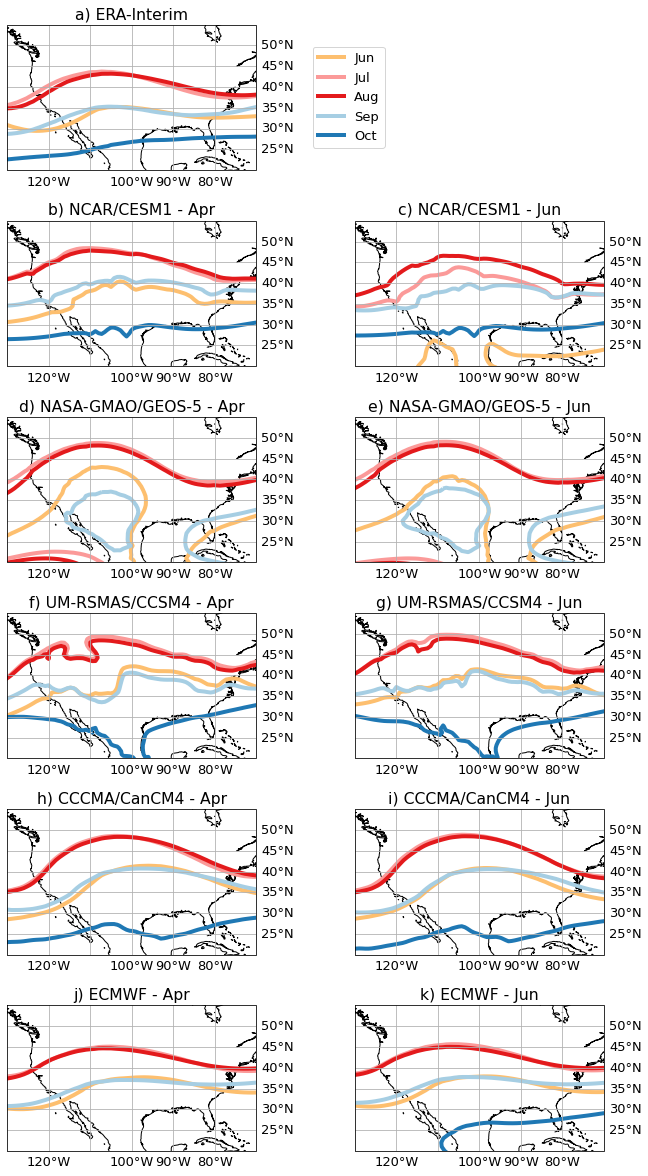

In [235]:
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm

ObjectsSort = ['MCSs','MCS_PR'] 
WTnames = ['dry','normal','monsoon']
Colors = ['#fdbf6f','#fb9a99','#e31a1c','#a6cee3','#1f78b4']
rgsMonths = ['Jun','Jul','Aug','Sep','Oct']
FCmonths = ['Apr','Jun']

plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(10,17))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(6,2)
gs1.update(left=0.03, right=0.96,
   bottom=0.05, top=0.97,
   wspace=0.08, hspace=0.35)

# --------------
# Plot ERA-Inerim data
proj = ccrs.PlateCarree(0) #ccrs.Robinson()
ax = plt.subplot(gs1[0,0], projection=proj)

for mm in range(len(MONTHS)):
    CS = plt.contour(rgrLonWT,rgrLatWT,ERAI_monclim[mm,:,:]/9.81, levels=[57500/9.81], colors=Colors[mm], linewidths=4)
    ax.plot([-99,-99],[-99,-99], color=Colors[mm], lw=4, label=rgsMonths[mm])

ax.coastlines()
ax.set_extent((-130, -70, 20, 55), ccrs.PlateCarree())
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.left_labels = False
gl.top_labels = False

plt.title('a) ERA-Interim')

# -------------
# plot the NMME results
for mo in range(NMME_clim.shape[4]):
    for lm in range(NMME_clim.shape[1]):
        ax = plt.subplot(gs1[mo+1,lm], projection=proj)

        for mm in range(len(MONTHS)):
            if np.mean(NMME_clim[mm,lm,:,:,mo], axis=(0,1)) > 50000:
                CS = plt.contour(WTlon,WTlat,NMME_clim[mm,lm,:,:,mo]/9.81, levels=[57500/9.81], colors=Colors[mm], linewidths=4)
            else:
                CS = plt.contour(WTlon,WTlat,NMME_clim[mm,lm,:,:,mo], levels=[57500/9.81], colors=Colors[mm], linewidths=4)

        ax.coastlines()
        ax.set_extent((-130, -70, 20, 55), ccrs.PlateCarree())
        plt.title(rgsLableABC[int(1+lm+mo*2)]+') '+NMME_models[mo][0]+' - '+FCmonths[lm])
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.left_labels = False
        gl.top_labels = False


# -------------
# plot the ECMWF data
for lm in range(NMME_clim.shape[1]):
    ax = plt.subplot(gs1[mo+2,lm], projection=proj)

    for mm in range(len(MONTHS)):
        if lm == 0:
            DATA = AprilDat 
        else:
            DATA = JuneDat
        try:
            CS = plt.contour(rgrLon75,rgrLat75,DATA[mm,:,:], levels=[57500/9.81], colors=Colors[mm], linewidths=4)
        except:
            continue

    ax.coastlines()
    ax.set_extent((-130, -70, 20, 55), ccrs.PlateCarree())
    plt.title(rgsLableABC[3+int(lm+mo*2)]+') ECMWF - '+FCmonths[lm])
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.left_labels = False
    gl.top_labels = False


sPlotFile=''
sPlotName= 'North_American-monsoon-ridge.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

In [1]:
57500/9.81

5861.3659531090725

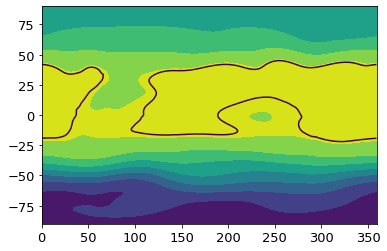

In [222]:
plt.contourf(rgrLon75,rgrLat75, AprilDat[1,:,:])
plt.contour(rgrLon75,rgrLat75, AprilDat[1,:,:], levels=[57500/9.81])

In [214]:
np.mean(AprilDat, axis=(1,2))

array([5557.37714309, 5565.42405888, 5555.45006582, 5530.33495943])

In [220]:
WTlon

array([[-135.  , -134.25, -133.5 , ...,  -69.75,  -69.  ,  -68.25],
       [-135.  , -134.25, -133.5 , ...,  -69.75,  -69.  ,  -68.25],
       [-135.  , -134.25, -133.5 , ...,  -69.75,  -69.  ,  -68.25],
       ...,
       [-135.  , -134.25, -133.5 , ...,  -69.75,  -69.  ,  -68.25],
       [-135.  , -134.25, -133.5 , ...,  -69.75,  -69.  ,  -68.25],
       [-135.  , -134.25, -133.5 , ...,  -69.75,  -69.  ,  -68.25]])

In [124]:
NMMEdata.shape

(153, 18, 2, 50, 90, 1, 10, 4)